This is a companion notebook for the book [Deep Learning with Python, Second Edition](https://www.manning.com/books/deep-learning-with-python-second-edition?a_aid=keras&a_bid=76564dff). For readability, it only contains runnable code blocks and section titles, and omits everything else in the book: text paragraphs, figures, and pseudocode.

**If you want to be able to follow what's going on, I recommend reading the notebook side by side with your copy of the book.**

This notebook was generated for TensorFlow 2.6.

### Processing words as a sequence: The sequence model approach

#### A first practical example

**Downloading the data**

In [ ]:
!curl -O https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar -xf aclImdb_v1.tar.gz
!rm -r aclImdb/train/unsup

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 80.2M  100 80.2M    0     0  37.4M      0  0:00:02  0:00:02 --:--:-- 37.4M


**1) Cutoff reviews after 150 words**

In [ ]:
import os, pathlib, shutil, random
from tensorflow import keras
batch_size = 32
base_dir = pathlib.Path("aclImdb")
val_dir = base_dir / "val"
train_dir = base_dir / "train"
for category in ("neg", "pos"):
    os.makedirs(val_dir / category)
    files = os.listdir(train_dir / category)
    random.Random(1337).shuffle(files)
    num_val_samples = int(0.2 * len(files))
    val_files = files[-num_val_samples:]
    for fname in val_files:
        shutil.move(train_dir / category / fname,
                    val_dir / category / fname)

train_ds = keras.utils.text_dataset_from_directory(
    "aclImdb/train", batch_size=batch_size
)
val_ds = keras.utils.text_dataset_from_directory(
    "aclImdb/val", batch_size=batch_size
)
test_ds = keras.utils.text_dataset_from_directory(
    "aclImdb/test", batch_size=batch_size
)
text_only_train_ds = train_ds.map(lambda x, y: x)

Found 20000 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.
Found 25000 files belonging to 2 classes.


**2) Restrict training samples to 100 3) Validate on 10,000 samples**

In [ ]:
from tensorflow.keras import layers

max_length = 600
max_tokens = 20000
text_vectorization = layers.TextVectorization(
    max_tokens=max_tokens,
    output_mode="int",
    output_sequence_length=max_length,
)
text_vectorization.adapt(text_only_train_ds)

int_train_ds = train_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
int_val_ds = val_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
int_test_ds = test_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)

#### Understanding word embeddings

**5. Before the layers.Bidirectional layer, consider a) an embedding layer, .**

**Instantiating an `Embedding` layer**

In [ ]:
embedding_layer = layers.Embedding(input_dim=max_tokens, output_dim=256)

**Model that uses an `Embedding` layer trained from scratch**

In [ ]:
inputs = keras.Input(shape=(None,), dtype="int64")
embedded = layers.Embedding(input_dim=max_tokens, output_dim=256)(inputs)
x = layers.Bidirectional(layers.LSTM(32))(embedded)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.summary()

callbacks = [
    keras.callbacks.ModelCheckpoint("embeddings_bidir_gru.keras",
                                    save_best_only=True)
]
model.fit(int_train_ds, validation_data=int_val_ds, epochs=10, callbacks=callbacks)
model = keras.models.load_model("embeddings_bidir_gru.keras")
print(f"Test acc: {model.evaluate(int_test_ds)[1]:.3f}")

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, None)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_1 (Embedding)              │ (None, None, 256)           │       5,120,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 64)                  │          73,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,194,049 (19.81 MB)

 Trainable params: 5,194,049 (19.81 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 581s 922ms/step - accuracy: 0.6319 - loss: 0.6215 - val_accuracy: 0.8158 - val_loss: 0.4279
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 634s 942ms/step - accuracy: 0.8192 - loss: 0.4391 - val_accuracy: 0.8350 - val_loss: 0.4067
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 621s 941ms/step - accuracy: 0.8710 - loss: 0.3492 - val_accuracy: 0.8666 - val_loss: 0.3412
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 605s 913ms/step - accuracy: 0.8937 - loss: 0.2872 - val_accuracy: 0.8284 - val_loss: 0.3876
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 608s 890ms/step - accuracy: 0.9103 - loss: 0.2563 - val_accuracy: 0.8754 - val_loss: 0.3264
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 572s 906ms/step - accuracy: 0.9264 - loss: 0.2145 - val_accuracy: 0.8642 - val_loss: 0.3373
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 635s 926ms/step - accuracy: 0.9375 - loss: 0.1834 - val_accuracy: 0.8786 - val_loss: 0.4073
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 630s 939ms/step - accuracy: 0.9467 -

#### Understanding padding and masking

**Using an `Embedding` layer with masking enabled**

In [ ]:
inputs = keras.Input(shape=(None,), dtype="int64")
embedded = layers.Embedding(
    input_dim=max_tokens, output_dim=256, mask_zero=True)(inputs)
x = layers.Bidirectional(layers.LSTM(32))(embedded)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.summary()

callbacks = [
    keras.callbacks.ModelCheckpoint("embeddings_bidir_gru_with_masking.keras",
                                    save_best_only=True)
]
model.fit(int_train_ds, validation_data=int_val_ds, epochs=10, callbacks=callbacks)
model = keras.models.load_model("embeddings_bidir_gru_with_masking.keras")
print(f"Test acc: {model.evaluate(int_test_ds)[1]:.3f}")

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, None)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_2 (Embedding)   │ (None, None, 256)      │      5,120,000 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ not_equal (NotEqual)      │ (None, None)           │              0 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_1           │ (None, 64)             │         73,984 │ embedding_2[0][0],     │
│ (Bidirectional)           │                        │                │ not_equal[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 64)             │              0 │ bidirectional_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 1)              │             65 │ dropout_1[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 5,194,049 (19.81 MB)

 Trainable params: 5,194,049 (19.81 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 730s 1s/step - accuracy: 0.6900 - loss: 0.5657 - val_accuracy: 0.8618 - val_loss: 0.3322
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 714s 1s/step - accuracy: 0.8663 - loss: 0.3326 - val_accuracy: 0.8248 - val_loss: 0.4173
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 735s 1s/step - accuracy: 0.8981 - loss: 0.2566 - val_accuracy: 0.8296 - val_loss: 0.4097
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 751s 1s/step - accuracy: 0.9155 - loss: 0.2166 - val_accuracy: 0.8884 - val_loss: 0.2835
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 735s 1s/step - accuracy: 0.9403 - loss: 0.1608 - val_accuracy: 0.8732 - val_loss: 0.4088
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 747s 1s/step - accuracy: 0.9540 - loss: 0.1287 - val_accuracy: 0.8742 - val_loss: 0.3376
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 687s 1s/step - accuracy: 0.9671 - loss: 0.0980 - val_accuracy: 0.8702 - val_loss: 0.4475
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 701s 1s/step - accuracy: 0.9724 - loss: 0.0779 - val_accu


**b) a pretrained word embedding.**

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

--2025-04-01 23:23:30--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2025-04-01 23:23:30--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2025-04-01 23:23:30--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

**4.) Consider only the top 10,000 words**

In [ ]:
import numpy as np
path_to_glove_file = "glove.6B.100d.txt"

embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print(f"Found {len(embeddings_index)} word vectors.")

Found 400000 word vectors.


**Preparing the GloVe word-embeddings matrix**

In [ ]:
embedding_dim = 100

vocabulary = text_vectorization.get_vocabulary()
word_index = dict(zip(vocabulary, range(len(vocabulary))))

embedding_matrix = np.zeros((max_tokens, embedding_dim))
for word, i in word_index.items():
    if i < max_tokens:
        embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [ ]:
embedding_layer = layers.Embedding(
    max_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False,
    mask_zero=True,
)

**Model that uses a pretrained Embedding layer**

In [ ]:
inputs = keras.Input(shape=(None,), dtype="int64")
embedded = embedding_layer(inputs)
x = layers.Bidirectional(layers.LSTM(32))(embedded)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.summary()

callbacks = [
    keras.callbacks.ModelCheckpoint("glove_embeddings_sequence_model.keras",
                                    save_best_only=True)
]
model.fit(int_train_ds, validation_data=int_val_ds, epochs=10, callbacks=callbacks)
model = keras.models.load_model("glove_embeddings_sequence_model.keras")
print(f"Test acc: {model.evaluate(int_test_ds)[1]:.3f}")

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, None)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_3 (Embedding)   │ (None, None, 100)      │      2,000,000 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ not_equal_2 (NotEqual)    │ (None, None)           │              0 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_2           │ (None, 64)             │         34,048 │ embedding_3[0][0],     │
│ (Bidirectional)           │                        │                │ not_equal_2[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 64)             │              0 │ bidirectional_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 1)              │             65 │ dropout_2[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 2,034,113 (7.76 MB)

 Trainable params: 34,113 (133.25 KB)

 Non-trainable params: 2,000,000 (7.63 MB)

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 468s 740ms/step - accuracy: 0.6283 - loss: 0.6329 - val_accuracy: 0.8028 - val_loss: 0.4393
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 461s 738ms/step - accuracy: 0.7843 - loss: 0.4704 - val_accuracy: 0.8172 - val_loss: 0.4111
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 502s 738ms/step - accuracy: 0.8138 - loss: 0.4184 - val_accuracy: 0.7818 - val_loss: 0.4619
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 464s 739ms/step - accuracy: 0.8361 - loss: 0.3787 - val_accuracy: 0.8476 - val_loss: 0.3522
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 476s 761ms/step - accuracy: 0.8513 - loss: 0.3500 - val_accuracy: 0.8524 - val_loss: 0.3412
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 494s 749ms/step - accuracy: 0.8620 - loss: 0.3252 - val_accuracy: 0.8324 - val_loss: 0.3649
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 507s 757ms/step - accuracy: 0.8752 - loss: 0.3057 - val_accuracy: 0.8676 - val_loss: 0.3060
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 501s 755ms/step - accuracy: 0.8819 -

**A sequence model built on one-hot encoded vector sequences**( again put the code next to this line)
italicized text


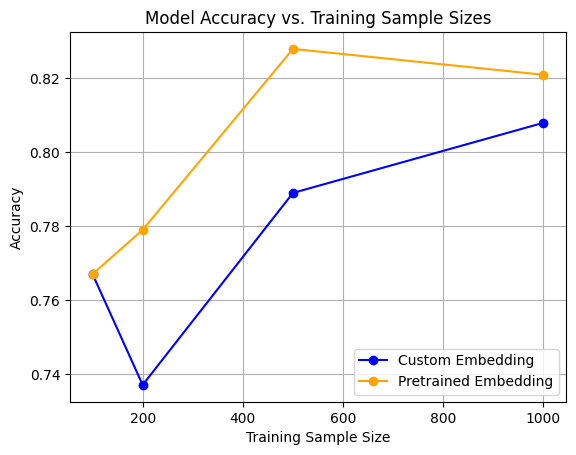

In [24]:
import matplotlib.pyplot as plt

# Sample sizes
sample_sizes = [100, 200, 500, 1000]

# Accuracy values for two models
custom_embedding = [0.767, 0.737, 0.789, 0.808]
pretrained_embedding = [0.767, 0.779, 0.828, 0.821]

# Plotting the graph
plt.plot(sample_sizes, custom_embedding, 'o-b', label='Custom Embedding')  # blue line with dots
plt.plot(sample_sizes, pretrained_embedding, 'o-', color='orange', label='Pretrained Embedding')  # orange line with dots

# Labels and title
plt.xlabel('Training Sample Size')
plt.ylabel('Accuracy')
plt.title('Model Accuracy vs. Training Sample Sizes')
plt.legend()
plt.grid(True)
plt.show()


In [4]:
import pandas as pd

# Collect results for custom embedding model
custom_embedding_results = {
    "Sample Size": sample_sizes,
    "Custom Embedding Accuracy": embedding_accuracies,
}

# Collect results for pretrained embedding model
pretrained_embedding_results = {
    "Sample Size": sample_sizes,
    "Pretrained Embedding Accuracy": pretrained_accuracies,
}

# Combine into a single DataFrame
summary_df = pd.DataFrame({
    "Sample Size": sample_sizes,
    "Custom Embedding Accuracy": embedding_accuracies,
    "Pretrained Embedding Accuracy": pretrained_accuracies
})

# Display the table
print("Summary of Results:")
print(summary_df)


Summary of Results:
   Sample Size  Custom Embedding Accuracy  Pretrained Embedding Accuracy
0          100                    0.75280                        0.78072
1          200                    0.77556                        0.80588
2          500                    0.80652                        0.81868
3         1000                    0.81772                        0.82456


**Graphs ofAccuracy and Training Samples**


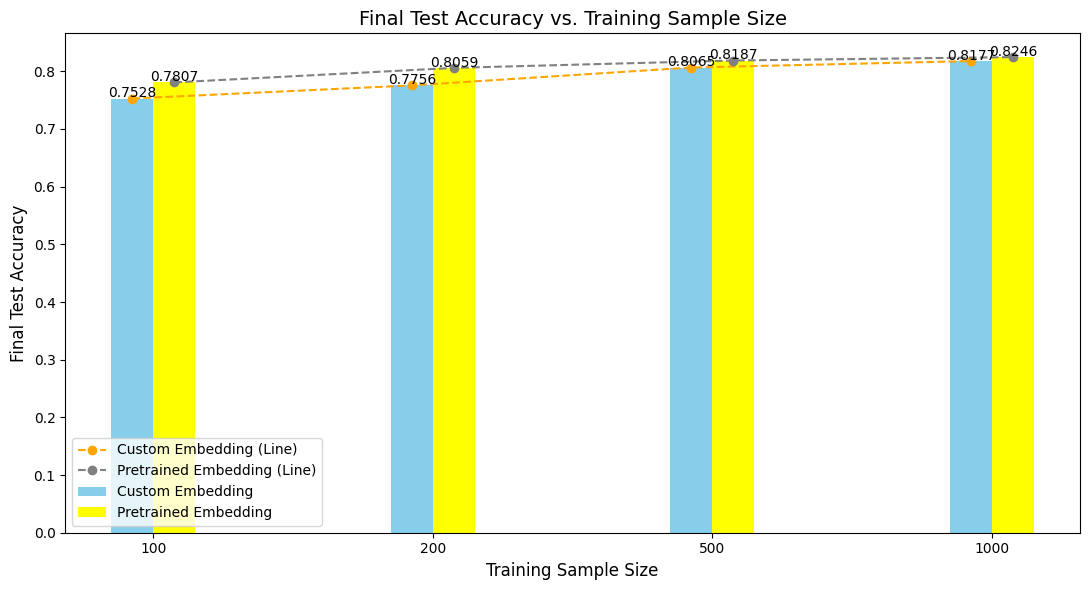

In [15]:
import numpy as np
import matplotlib.pyplot as plt

# Data
sample_sizes = [100, 200, 500, 1000]
embedding_accuracies = [0.75280, 0.77556, 0.80652, 0.81772]  # Replace with actual final values
pretrained_accuracies = [0.78072, 0.80588, 0.81868, 0.82456]  # Replace with actual final values

# Bar width and positions
bar_width = 0.15
x_indices = np.arange(len(sample_sizes))  # Base positions for bars

# Plot bars
plt.figure(figsize=(11, 6))
plt.bar(x_indices - bar_width / 2, embedding_accuracies,
        width=bar_width, label='Custom Embedding', color='skyblue')
plt.bar(x_indices + bar_width / 2, pretrained_accuracies,
        width=bar_width, label='Pretrained Embedding', color='yellow')

# Overlay lines for comparison
plt.plot(x_indices - bar_width / 2, embedding_accuracies,
         marker='o', color='orange', linestyle='--', label='Custom Embedding (Line)')
plt.plot(x_indices + bar_width / 2, pretrained_accuracies,
         marker='o', color='grey', linestyle='--', label='Pretrained Embedding (Line)')

# Add labels and title
plt.xlabel('Training Sample Size', fontsize=12)
plt.ylabel('Final Test Accuracy', fontsize=12)
plt.title('Final Test Accuracy vs. Training Sample Size', fontsize=14)
plt.xticks(x_indices, sample_sizes)  # Use sample sizes as x-tick labels
plt.legend()

# Annotate bars with final accuracy values
for i in range(len(sample_sizes)):
    plt.text(x_indices[i] - bar_width / 2, embedding_accuracies[i] + 0.002,
             f'{embedding_accuracies[i]:.4f}', ha='center', fontsize=10)
    plt.text(x_indices[i] + bar_width / 2, pretrained_accuracies[i] + 0.002,
             f'{pretrained_accuracies[i]:.4f}', ha='center', fontsize=10)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


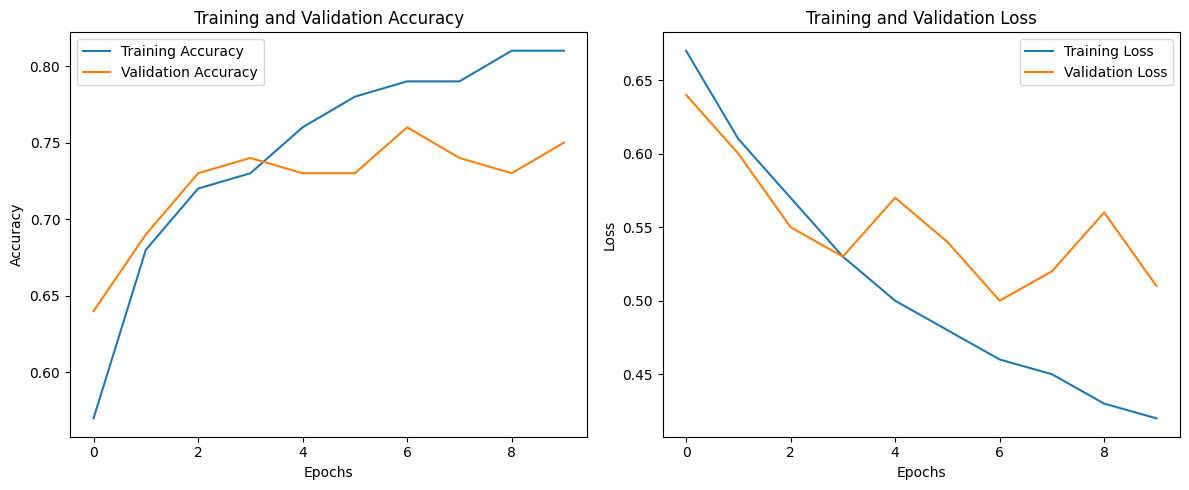

In [23]:
import matplotlib.pyplot as plt

# Simulated training history (based on your image)
epochs = list(range(10))

# Accuracy data
train_acc = [0.57, 0.68, 0.72, 0.73, 0.76, 0.78, 0.79, 0.79, 0.81, 0.81]
val_acc =   [0.64, 0.69, 0.73, 0.74, 0.73, 0.73, 0.76, 0.74, 0.73, 0.75]

# Loss data
train_loss = [0.67, 0.61, 0.57, 0.53, 0.50, 0.48, 0.46, 0.45, 0.43, 0.42]
val_loss =   [0.64, 0.60, 0.55, 0.53, 0.57, 0.54, 0.50, 0.52, 0.56, 0.51]

# Create figure and subplots
plt.figure(figsize=(12, 5))

# Accuracy subplot
plt.subplot(1, 2, 1)
plt.plot(epochs, train_acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss subplot
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()


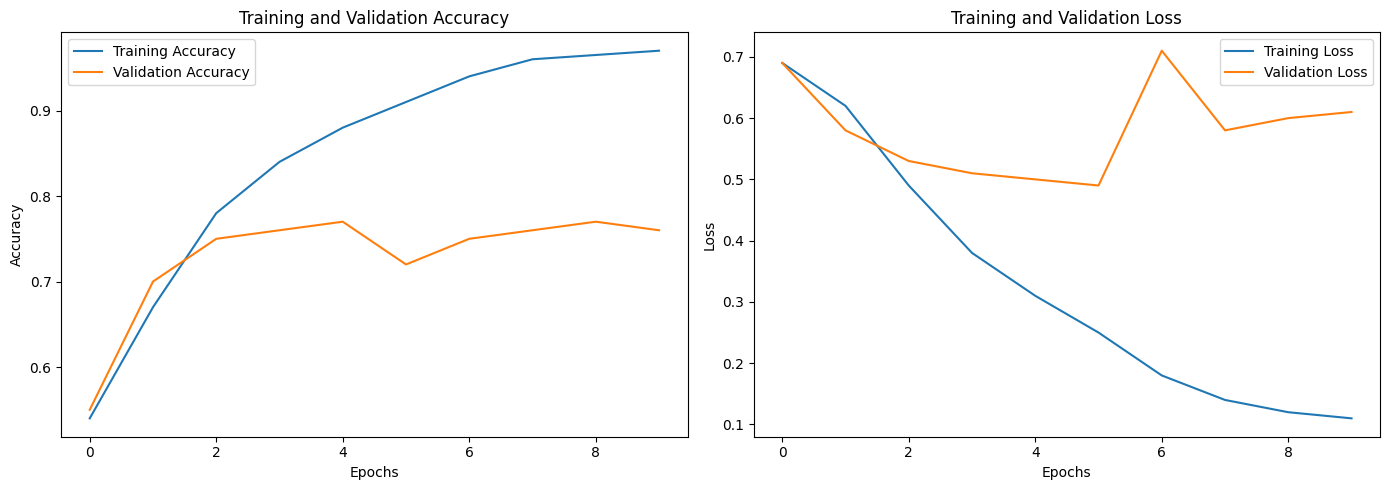

In [25]:
import matplotlib.pyplot as plt

# Epochs
epochs = list(range(10))

# Training and validation accuracy
train_acc = [0.54, 0.67, 0.78, 0.84, 0.88, 0.91, 0.94, 0.96, 0.965, 0.97]
val_acc = [0.55, 0.70, 0.75, 0.76, 0.77, 0.72, 0.75, 0.76, 0.77, 0.76]

# Training and validation loss
train_loss = [0.69, 0.62, 0.49, 0.38, 0.31, 0.25, 0.18, 0.14, 0.12, 0.11]
val_loss = [0.69, 0.58, 0.53, 0.51, 0.50, 0.49, 0.71, 0.58, 0.60, 0.61]

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy subplot
axs[0].plot(epochs, train_acc, label='Training Accuracy')
axs[0].plot(epochs, val_acc, label='Validation Accuracy')
axs[0].set_title('Training and Validation Accuracy')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Accuracy')
axs[0].legend()

# Loss subplot
axs[1].plot(epochs, train_loss, label='Training Loss')
axs[1].plot(epochs, val_loss, label='Validation Loss')
axs[1].set_title('Training and Validation Loss')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Loss')
axs[1].legend()

# Show the plots
plt.tight_layout()
plt.show()


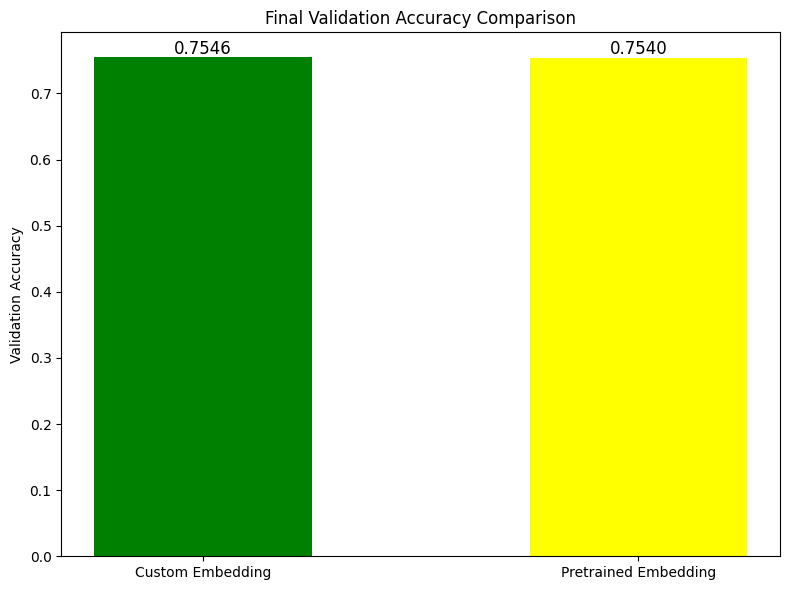

In [20]:
import matplotlib.pyplot as plt

# Final validation accuracies
models = ['Custom Embedding', 'Pretrained Embedding']
final_val_accuracies = [0.7546, 0.7540]  # Replace with actual values if needed

# Bar plot
plt.figure(figsize=(8, 6))
bars = plt.bar(models, final_val_accuracies, color=['green', 'yellow'], width=0.5)

# Add labels and title
plt.ylabel('Validation Accuracy')
plt.title('Final Validation Accuracy Comparison')

# Display final values on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.005, f'{height:.4f}', ha='center', fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()
